# Species definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel

In [2]:
def run_model():
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    elevation = X + r.rand(*Y.shape)
    pop_size = 10
    num_gen = 10
    model = IR12SpeciationModel(X, Y, pop_size,
                                nb_radius=50, car_cap=50,
                                sigma_w=0.2, sigma_mov=5, sigma_mut=0.05,
                                lifespan=1, mut_prob=0.05, random_seed=1234)
    model.initialize([[0.5, 0.5]])
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(elevation, elevation.min(), elevation.max(), 1)
        dfs.append(model.to_dataframe())
        model.update_population(1)
    return pd.concat(dfs).reset_index(drop=True), elevation, num_gen, X

In [3]:
population1, elevation, num_gen, X = run_model()

In [4]:
def plot_sol(population1, elevation, num_gen, X):
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(population1.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=population1['step'], y=population1['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(population1['x'].loc[population1['step']==max(population1['step'])],
                       population1['y'].loc[population1['step']==max(population1['step'])],
                       c=population1['trait_0'].loc[population1['step']==max(population1['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=population1['x'].loc[population1['step']==max(population1['step'])],
                                     y=population1['trait_0'].loc[population1['step']==max(population1['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

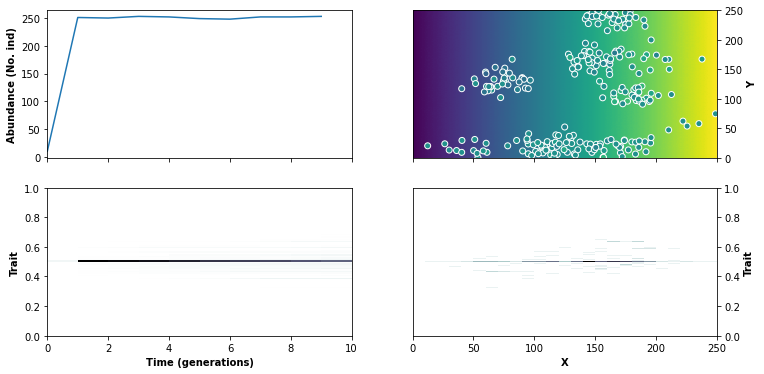

In [5]:
plot_sol(population1, elevation, num_gen, X)

In [6]:
def spp_lineage(population):
    _spp_id = np.array([])
    _spp_clus = np.array([])
    _spp_parent = np.array([])
    col_traits = population.columns[population.columns.str.contains('trait_')].to_list()
    for i in population.groupby('time').groups.keys():
        clus_dat = population.groupby('time').get_group(i)
        lineage = linkage(clus_dat[col_traits].to_numpy(), method='ward')
        _clus = fcluster(lineage, 0.5, 'distance')
        if i == 0:
            _spp_id = np.append(_spp_id, _clus)
            _spp_clus = np.append(_spp_clus, _clus)
            _spp_parent = np.append(_spp_parent, _clus)
            previous_spp_id = _clus
        else:
            parent_spp_id = np.repeat(previous_spp_id, previous_n_offspring)
            previous_spp_id = _clus + _spp_id.max()
            _spp_id = np.append(_spp_id, _clus + _spp_id.max())
            _spp_clus = np.append(_spp_clus, _clus)
            _spp_parent = np.append(_spp_parent, parent_spp_id)
        previous_n_offspring = clus_dat.n_offspring

    df_out = pd.DataFrame({'spp_id': _spp_id, 'spp_clus': _spp_clus, 'spp_parent': _spp_parent}, dtype="int8")
    trait_spp = (population1.join(df_out)
                 .groupby(['time', 'spp_id', 'spp_parent'])['trait_0']
                 .mean()
                 .reset_index()
                 )
    abun_spp = (population1.join(df_out).groupby(['time', 'spp_id', 'spp_parent'])
                .size()
                .rename('abundance')
                .reset_index()
                )

    return pd.merge(trait_spp, abun_spp).rename(columns={'spp_id': 'id', 'spp_parent': 'parent'})

In [7]:
dtf_out = spp_lineage(population1)
tree_spp = (dtf_out.assign(node_type=dtf_out.ptree.node_type,
                tree_id=dtf_out.ptree.tree_id,
                length=dtf_out.ptree.branch_length('time'))
            )
tree_spp

,time,id,parent,trait_0,abundance,node_type,tree_id,length
0,0.0,1,1,0.500000,10,root,1,0.0
1,1.0,2,1,0.499174,251,node,1,1.0
2,2.0,3,2,0.499883,250,node,1,1.0
3,3.0,4,3,0.500391,253,node,1,1.0
4,4.0,5,4,0.500080,252,node,1,1.0
5,5.0,6,5,0.498176,249,node,1,1.0
6,6.0,7,6,0.426416,29,node,1,0.0
7,6.0,8,6,0.505549,219,node,1,1.0
8,7.0,9,7,0.417141,34,node,1,1.0
9,7.0,10,8,0.598478,16,node,1,0.0


In [8]:
def plot_tree(G, pos=None, root=None, alpha=0.5, node_size=40,
              node_color='trait_0', cmap=plt.cm.viridis,
              edge_color=None, edge_cmap=plt.cm.gray):
    if pos is None:
        pos = graphviz_layout(G, prog='twopi', root=root)
    else:
        x, y = pos
        pos = {k: (v[x], v[y]) for k, v in G.nodes.data()}

    node_data = [n.get(node_color) for n in G.nodes.values()]
    vmin = min(node_data)
    vmax = max(node_data)

    if edge_color is None:
        edge_data = 'k'
    else:
        edge_data = [e.get(edge_color) for e in G.edges.values()]

    fig, ax = plt.subplots(figsize=(14, 12))

    nx.draw(G, pos=pos, ax=ax, alpha=alpha,
            node_size=node_size, node_color=node_data,
            cmap=cmap, vmin=vmin, vmax=vmax,
            edge_color=edge_data, edge_cmap=edge_cmap)

    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    return fig, ax

(<Figure size 1008x864 with 2 Axes>, <AxesSubplot:>)

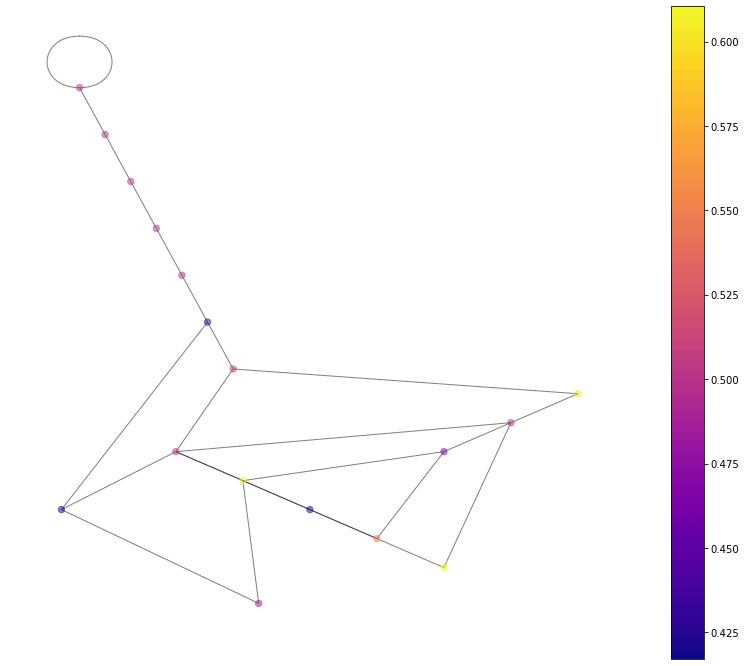

In [9]:
G1_0 = (tree_spp.ptree.drop_disconnected_roots().ptree.to_networkx(node_col='trait_0'))
plot_tree(G1_0, root=None, cmap=plt.cm.plasma)